In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from dataset import LayoutDataset
from models import LayoutMLP
from scipy.stats import kendalltau

2023-10-20 20:28:52.942642: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-20 20:28:53.862178: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
batch_size = 192
learning_rate = 1e-3
batch_per_file_size = 8
decay_rate = 0.95
node_embedding_size = 12
layers = [32, 12, 32, 8]

dataset = LayoutDataset(
    batch_size, train_sample_fraction=1.0,
    subset=None, build_tfrecords=False,
    batch_per_file_size=batch_per_file_size
)

2023-10-20 20:28:55.053300: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-20 20:28:55.131510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-20 20:28:55.131771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
mlp = LayoutMLP(
    batch_size,
    learning_rate=learning_rate,
    mask_max_len=dataset.n_config_nodes_upper_limit,
    batch_per_file_size=batch_per_file_size,
    decay_rate=decay_rate,
    node_embedding_size=node_embedding_size,
    validation_frequency=10_000,
    validations_without_improvement=3,
    layer_sizes=layers,
    loss='pairwise_hinge',
    l1_multiplier=1e-9,
    n_siblings=dataset.n_siblings
)

mlp.train(dataset, None)

2023-10-20 20:30:49.847569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-20 20:30:49.889870: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1d54070380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-20 20:30:49.889906: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-10-20 20:30:49.914998: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-20 20:30:50.126904: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-20 20:30:50.258393: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

iteration 500 training loss 3.2130444 lr 0.00010
iteration 1000 training loss 2.4535983 lr 0.00020
iteration 1500 training loss 2.5992198 lr 0.00030
iteration 2000 training loss 1.8455851 lr 0.00040
iteration 2500 training loss 2.169483 lr 0.00050
iteration 3000 training loss 2.363824 lr 0.00060
iteration 3500 training loss 2.0595531 lr 0.00070
iteration 4000 training loss 1.9861069 lr 0.00080
iteration 4500 training loss 2.0314496 lr 0.00090
iteration 5000 training loss 1.8852594 lr 0.00100
iteration 5500 training loss 1.7636421 lr 0.00100
iteration 6000 training loss 1.6881143 lr 0.00100
iteration 6500 training loss 2.032578 lr 0.00100
iteration 7000 training loss 1.82599 lr 0.00100
iteration 7500 training loss 2.0133996 lr 0.00100
iteration 8000 training loss 1.3540308 lr 0.00100
iteration 8500 training loss 1.3307632 lr 0.00100
iteration 9000 training loss 1.8346215 lr 0.00100
iteration 9500 training loss 1.3250351 lr 0.00100
iteration 10000 training loss 1.7657578 lr 0.00100
layou

iteration 70000 training loss 1.3023053 lr 0.00061
layout:nlp:random 0.8590303547333644
layout:nlp:default 0.44824585922398724
layout:xla:random 0.5442976406091379
layout:xla:default 0.290392272362792
epoch 0, it 70000 validation loss -0.535
iteration 70500 training loss 1.5151752 lr 0.00060
iteration 71000 training loss 1.540346 lr 0.00060
iteration 71500 training loss 1.2622757 lr 0.00059
iteration 72000 training loss 1.2175941 lr 0.00059
iteration 72500 training loss 1.1539783 lr 0.00058
iteration 73000 training loss 1.348223 lr 0.00058
iteration 73500 training loss 1.3263848 lr 0.00057
iteration 74000 training loss 1.3598523 lr 0.00057
iteration 74500 training loss 1.3041689 lr 0.00056
iteration 75000 training loss 1.2498015 lr 0.00056
iteration 75500 training loss 1.056568 lr 0.00055
iteration 76000 training loss 1.5596087 lr 0.00055
iteration 76500 training loss 1.1346499 lr 0.00054
iteration 77000 training loss 1.3886695 lr 0.00054
iteration 77500 training loss 0.8907785 lr 0.00

iteration 137000 training loss 0.836668 lr 0.00004
iteration 137500 training loss 1.2677146 lr 0.00004
iteration 138000 training loss 1.3054235 lr 0.00004
iteration 138500 training loss 1.1684847 lr 0.00004
iteration 139000 training loss 1.066419 lr 0.00004
iteration 139500 training loss 1.2369864 lr 0.00004
iteration 140000 training loss 1.1149782 lr 0.00003
layout:nlp:random 0.8748556677106712
layout:nlp:default 0.4722035955578555
layout:xla:random 0.5855346476866945
layout:xla:default 0.30813829981843305
epoch 0, it 140000 validation loss -0.560
iteration 140500 training loss 1.2608333 lr 0.00003
iteration 141000 training loss 1.1626089 lr 0.00003
iteration 141500 training loss 1.5694433 lr 0.00003
iteration 142000 training loss 1.2919897 lr 0.00003
iteration 142500 training loss 1.4185987 lr 0.00003
iteration 143000 training loss 1.0323727 lr 0.00003
iteration 143500 training loss 1.0093263 lr 0.00002
iteration 144000 training loss 0.9932419 lr 0.00002
iteration 144500 training los

## Evaluate validation set

In [4]:
val_df = mlp.predict_over_dataset(dataset.valid_data, return_labels=True)

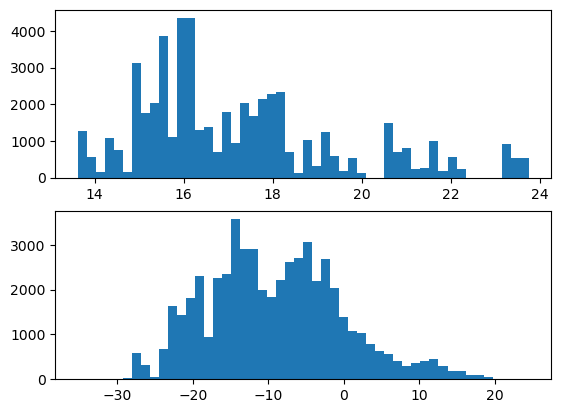

In [5]:
plt.subplot(2, 1, 1)
plt.hist(val_df['target'], bins=50)
plt.subplot(2, 1, 2)
plt.hist(val_df['prediction'], bins=50);

In [6]:
val_df.groupby('ID').apply(lambda x: x.min()).sort_values('prediction')

,ID,config_index,prediction,target
ID,,,,
b'layout:nlp:random:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train',b'layout:nlp:random:small_bert_bert_en_uncased...,90,-35.224632,15.867647
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train',b'layout:nlp:default:small_bert_bert_en_uncase...,181,-28.382187,15.862173
b'layout:nlp:random:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train',b'layout:nlp:random:bert_multi_cased_L-12_H-76...,2,-28.367405,17.404436
b'layout:nlp:random:small_bert_bert_en_uncased_L-12_H-768_A-12_batch_size_64_train',b'layout:nlp:random:small_bert_bert_en_uncased...,9,-28.358089,18.142101
b'layout:nlp:random:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train',b'layout:nlp:random:small_bert_bert_en_uncased...,36,-27.906857,16.526739
b'layout:nlp:random:small_bert_bert_en_uncased_L-10_H-768_A-12_batch_size_16_train',b'layout:nlp:random:small_bert_bert_en_uncased...,55,-27.759901,17.054892
b'layout:nlp:random:small_bert_bert_en_uncased_L-6_H-768_A-12_batch_size_32_train',b'layout:nlp:random:small_bert_bert_en_uncased...,71,-26.188023,17.015703
b'layout:nlp:random:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_64_train',b'layout:nlp:random:small_bert_bert_en_uncased...,34,-25.875622,16.084629
b'layout:nlp:random:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train',b'layout:nlp:random:small_bert_bert_en_uncased...,5,-24.626337,15.198507


Text(0.5, 1.0, "b'layout:xla:random:mlperf_bert_batch_24_2x2'")

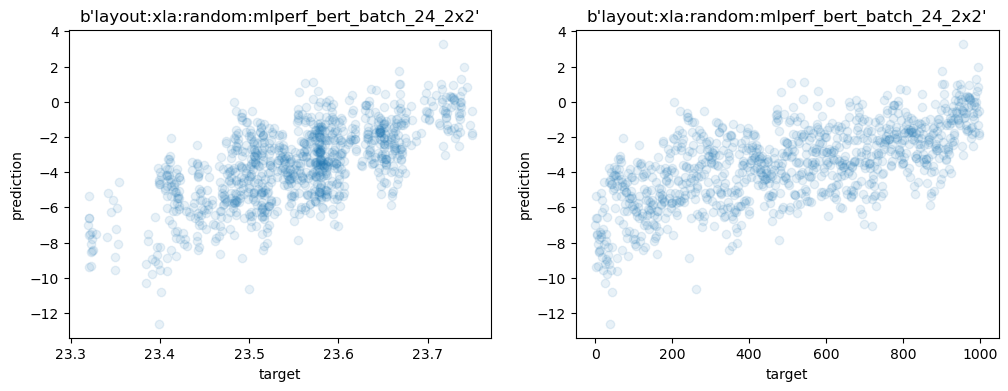

In [22]:
x_lin = np.linspace(15, 25, 100)
#plt.plot(x_lin, x_lin, color='orange')

random_sample = val_df.sample(1_000)
graph_id = np.random.choice(val_df['ID'].unique())
#graph_id = b'layout:xla:default:inception_v3_batch_128_train'
#graph_id = b'layout:xla:default:unet_3d.4x4.bf16'
random_sample = val_df[val_df['ID'] == graph_id].copy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample.target,
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

random_sample.sort_values('target', inplace=True)
plt.subplot(1, 2, 2)
plt.scatter(
    np.arange(len(random_sample)),
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

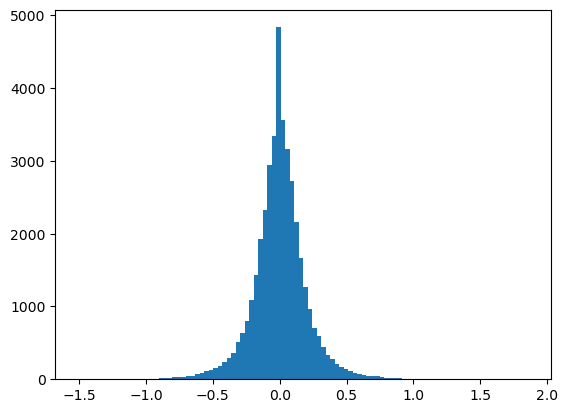

In [23]:
plt.hist(mlp.k_layer.kernel.numpy().flatten(), bins=100);

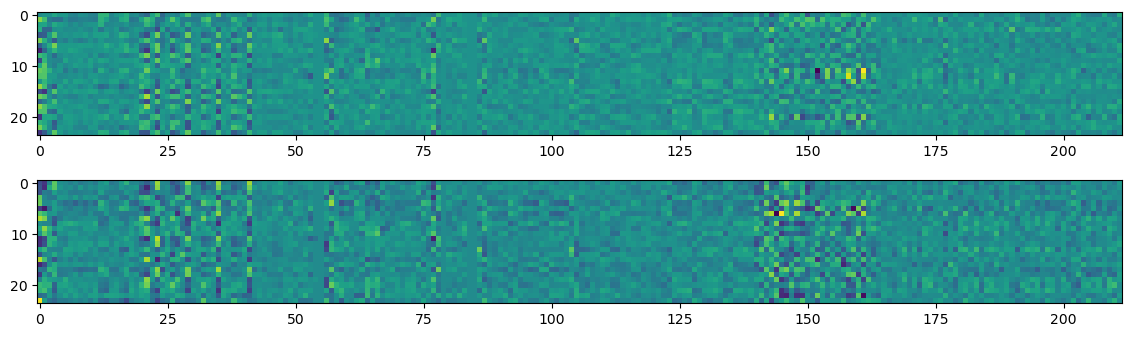

In [30]:
plt.figure(figsize=(14, 4))
kind = 2
plt.subplot(2, 1, 1)
k_vals = mlp.k_layer.kernel.numpy().reshape(212, 8, -1)[:, kind, :].T
plt.imshow(k_vals)

plt.subplot(2, 1, 2)
q_vals = mlp.q_layer.kernel.numpy().reshape(212, 8, -1)[:, kind, :].T
plt.imshow(q_vals)

00        interesting features (20)
            np.arange(21, 27),  # shape dims
            np.arange(31, 37),  # reshape/broadcast dims
            np.arange(95, 99),  # conv dims input
            np.arange(101, 105),  # conv dims kernel
20        parent output shapes (12)
32        sibling shapes (n_siblings*6)
50        physical layout (6)
56        node layout (18)
74        parent phys layout (12)
86        siblings layout (n_sibling*18)
140        parent opcodes (2)
164        sibling opcodes (n_siblings)
200        opcode (1)

In [74]:
lens = [20, 12, 18, 6, 18, 12, 18*3, 24, 36, 12]
np.cumsum(lens)

array([ 20,  32,  50,  56,  74,  86, 140, 164, 200, 212])

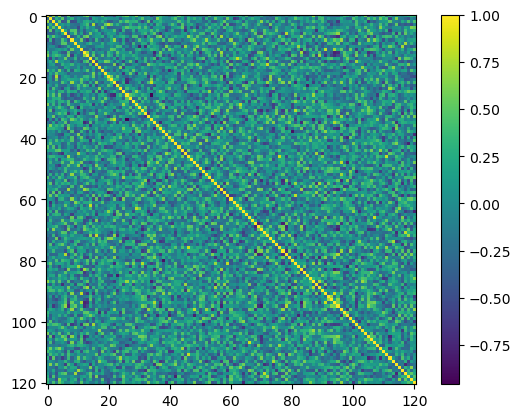

In [31]:
emb = mlp.embedding_layer_node_ops.weights[0].numpy()
emb = emb / np.expand_dims(np.linalg.norm(emb, axis=1), axis=-1)
dots = np.matmul(emb, emb.T)
plt.imshow(dots)
plt.colorbar()

In [ ]:
dots[34, 26]

In [32]:
np.argsort(dots[26])

array([ 34,  22,  21,  73, 108,  47,   8,  76,  52, 111,  80,  11,  41,
         6,  20,   5, 115,  16,   9,  57,  97,  99,  69,  91,  94,  51,
        72,  49,  61,  46, 106,  60,  62,  67,  96,  82,  79,  48, 116,
        14, 102,   3,  63,  77, 105, 107,  95,  25,  40,  66,  54, 100,
        45,  35,  44,  10,  71, 118,  78,  30, 120,  98,  70,  33,  12,
        83,  55,  92,  64,  15,   7,  84,  86, 114,  39,  88,   1,  36,
        13,  19, 119, 117,  68, 104,  53,  37,  29,  89,  93,  23,  17,
        32,  74,  50,  38,  90,  43, 112,  85,  18, 109,  75,  56, 113,
        31,  42,  28,  24, 110,  58, 101,   2,  59, 103,  27,   4,   0,
        65,  81,  87,  26])

In [34]:
ind = np.unravel_index(np.argsort(dots.flatten())[-122], dots.shape)
ind

(66, 107)

In [ ]:
val_df[val_df['ID'] == b'layout:xla:default:unet_3d.4x4.bf16'].sort_values('target')

In [ ]:
for val_batch in dataset.valid_data:
    if b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy():
        print(val_batch['layout_id'])
        break

In [ ]:
np.unique(val_batch['layout_id'].numpy())

In [ ]:
b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy()

In [ ]:
layout_ids = val_batch['layout_id']
config_descriptor = val_batch['node_descriptor']
valid_mask = val_batch['valid_nodes']
graph_descriptor = val_batch['graph_descriptor']

with tf.device('/cpu:0'):
    subset_info_str = tf.map_fn(
        lambda layout_id: tf.strings.reduce_join(
            tf.strings.split(layout_id, ":")[:3]),
        layout_ids
    )

subset_info = mlp.text_vectorization(subset_info_str)
subset_info = tf.expand_dims(subset_info, axis=-1)
subset_info = mlp.embedding_layer_subset_info(subset_info)
subset_info = subset_info[:, 0, :]

# for si, sn in zip(subset_info_str.numpy(), subset_info.numpy()):
#     print(si, sn)

node_operations = config_descriptor[:, :, -1]
config_descriptor = config_descriptor[:, :, :-1]
node_operations = tf.cast(node_operations, tf.int32)
# node_operations.shape == (batch_size, mask_max_len)                                                                                                                                 
node_embedding = mlp.embedding_layer_node_ops(node_operations)
# node_embedding.shape == (batch_size, mask_max_len, embed_len)
# np.unique(node_operations.numpy().flatten(), return_counts=True)

x = mlp.normalization_layer_config_nodes(config_descriptor)
normal_graph_descriptor = mlp.normalization_layer_graph_descriptor(graph_descriptor)
x = tf.concat([x, node_embedding], axis=-1)

x = mlp.dense_layer_node_1(x)
x = mlp.relu_layer(x)  # (batch_size, n_config_nodes_upper_limit, n_units)                                                                                                           
x = mlp.dense_layer_node_2(x)
x = mlp.relu_layer(x)  # (batch_size, n_config_nodes_upper_limit, n_units)                                                                                                           

# plt.hist(x.numpy().flatten(), bins=100);
float_mask = tf.sequence_mask(valid_mask, mlp.mask_max_len, dtype=tf.float32)
# (batch_size, n_config_nodes_upper_limit)                                                                                                                                            

float_mask = tf.expand_dims(float_mask, axis=-1)
x = x * float_mask

x = tf.reduce_sum(x, axis=1)
#plt.subplot(2, 1, 1)
#plt.hist(x.numpy().flatten(), bins=100);

x = x / tf.expand_dims(tf.cast(valid_mask, tf.float32), axis=-1)
#plt.subplot(2, 1, 2)
#plt.hist(x.numpy().flatten(), bins=100);
for i, lid, gd, nd in zip(range(96), layout_ids.numpy(), graph_descriptor.numpy(), normal_graph_descriptor.numpy()):
    if i in [19]:
        print(i, gd[80:90], nd[80:90], lid)
x = tf.concat([x, normal_graph_descriptor, subset_info], axis=-1)
#plt.hist(x.numpy().flatten(), bins=100);
x = mlp.dense_layer_global_1(x)
x = mlp.relu_layer(x)
#plt.hist(x.numpy().flatten(), bins=100);
x = mlp.dense_layer_global_2(x)
x = mlp.relu_layer(x)
#plt.hist(x.numpy().flatten(), bins=100);
x = mlp.dense_layer_global_3(x)
x = tf.reshape(x, (-1,))
x

In [ ]:
random_sample = val_df.sample(5_000)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample['target'],
    np.abs(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('abs error')
x_lin = np.linspace(0, 0.7, 100)
#plt.plot(x_lin, x_lin, color='orange')


plt.subplot(1, 2, 2)
plt.scatter(
    random_sample['target'],
    np.square(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('squared error')

In [35]:
def sort_configs(df):
    top = df.sort_values('prediction')
    top = top['config_index'].values.tolist()
    top = [str(i) for i in top]
    return ';'.join(top)

val_prediction = val_df.groupby('ID').apply(sort_configs)
val_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
val_prediction

ID
layout:nlp:default:albert_en_xlarge_batch_size_16_test                               33678;24643;35044;31024;35867;34193;14435;452;...
layout:nlp:default:bert_en_cased_L-12_H-768_A-12_batch_size_16_test                  38717;38806;61459;72662;59451;17642;84776;8481...
layout:nlp:default:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train              28224;22895;22921;22854;28112;15640;2448;2421;...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_32_test      82270;2161;63068;91976;2063;39227;53868;69316;...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train     49047;11573;48492;9242;39779;17780;9616;32725;...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_32_test      21237;93813;37443;30714;31098;82270;90462;9047...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train     986;1034;25802;6604;1003;25821;21464;36363;482...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H

In [36]:
val_df

,ID,config_index,prediction,target
0,b'layout:xla:default:bert_pretraining.4x4.fp16',10038,-14.119782,17.648029
1,b'layout:nlp:default:bert_en_cased_L-12_H-768_...,33423,-17.006845,15.545840
2,b'layout:nlp:default:bert_en_cased_L-12_H-768_...,89910,-16.358519,15.546324
3,b'layout:xla:default:bert_pretraining.4x4.fp16',5484,-14.168186,17.647877
4,b'layout:nlp:default:bert_en_cased_L-12_H-768_...,85188,-16.247168,15.546723
...,...,...,...,...
53476,b'layout:nlp:random:small_bert_bert_en_uncased...,5067,1.889208,17.367647
53477,b'layout:nlp:random:small_bert_bert_en_uncased...,16675,-15.082200,17.131214
53478,b'layout:nlp:random:small_bert_bert_en_uncased...,34977,1.956805,17.374754
53479,b'layout:nlp:random:small_bert_bert_en_uncased...,40047,-7.944080,17.241798


In [37]:
val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3])).unique()

array(['layout:xla:default', 'layout:nlp:default', 'layout:nlp:random',
       'layout:xla:random'], dtype=object)

In [38]:
def compute_layout_score_group(df):
    score, _ = kendalltau(df['prediction'], df['target'])
    return score

val_df['subset'] = val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3]))
for subset in val_df['subset'].unique():
    mean = np.mean(val_df[val_df['subset'] == subset].groupby('ID').apply(compute_layout_score_group))
    print(subset, mean)

layout:xla:default 0.3161876266989002
layout:nlp:default 0.4670123573448673
layout:nlp:random 0.8928181652358473
layout:xla:random 0.6088011138754252


In [36]:
np.mean([0.4185, 0.8167, 0.538, 0.2525])

0.506425

In [39]:
val_scores = val_df.groupby('ID').apply(compute_layout_score_group)
val_scores.sort_values()

ID
b'layout:xla:default:unet_3d.4x4.bf16'                                                 -0.021794
b'layout:xla:random:unet_3d.4x4.bf16'                                                   0.211465
b'layout:xla:default:resnet_v1_50_official_batch_128_bf16'                              0.302864
b'layout:xla:default:mlperf_bert_batch_24_2x2'                                          0.332344
b'layout:xla:default:tf2_bert_pretrain_dynamic_batch_size'                              0.332868
b'layout:xla:default:inception_v3_batch_128_train'                                      0.349533
b'layout:nlp:default:albert_en_xlarge_batch_size_16_test'                               0.355135
b'layout:nlp:default:small_bert_bert_en_uncased_L-4_H-512_A-8_batch_size_32_train'      0.355433
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-512_A-8_batch_size_64_test'      0.361132
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train'     0.403623
b'layout:nlp:default:small_

In [ ]:
def layout_score(candidate_order, layout_dict):
    runtimes = layout_dict['config_runtime']
    best_ranking = np.argsort(runtimes)
    assert len(candidate_order) == len(runtimes)
    score, _ = kendalltau(candidate_order, best_ranking)
    return score

In [ ]:
dirpath, filename

In [ ]:
true_order = np.argsort(layout_dict['config_runtime'])
plt.scatter(true_order, candidate_order)

In [ ]:
layout_set = 'valid'
true_orders = []
layout_ids = []
for dirpath, dirnames, filenames in os.walk('predict-ai-model-runtime/npz_all/npz/layout'):
    if len(filenames) == 0:
        continue
    
    if dirpath.split('/')[-1] != layout_set:
        continue
        
    layout_id_prefix = ':'.join(dirpath.split('/')[-4:-1])
    for filename in os.listdir(dirpath):
        print(filename)
        layout_id = layout_id_prefix+':'+filename[:-4]
        layout_dict = dict(np.load(os.path.join(dirpath, filename)))
        runtimes = layout_dict['config_runtime']
        best_ranking = np.argsort(runtimes)
        best_ranking = ';'.join([str(i) for i in best_ranking])
        true_orders.append(best_ranking)
        layout_ids.append(layout_id)
        
true_order_df = pd.DataFrame(
    data=np.stack([layout_ids, true_orders], axis=-1),
    columns=['ID', 'true_order']
)
true_order_df

In [ ]:
# layout_id = true_order_df.sample()['ID'].values[0]
layout_id = 'layout:xla:default:resnet50.4x4.fp16'
true_order = [int(i) for i in true_order_df[true_order_df['ID'] == layout_id]['true_order'].values[0].split(';')]
candidate_order = [int(i) for i in val_prediction[layout_id].split(';')]

plt.scatter(true_order, candidate_order)
plt.xlabel('true order')
plt.ylabel('candidate order')
plt.title(f'{layout_id}, len {len(true_order)}')

In [ ]:
layout_dict = dict(np.load('predict-ai-model-runtime/npz_all/npz/layout/nlp/default/valid/small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train.npz'))
layout_dict['node_config_feat'].shape

In [ ]:
val_df[val_df['ID'] == b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train']

In [ ]:
evaluation_result_layout['score'].astype(float).mean()

## Inference over test set

In [40]:
test_df = mlp.predict_over_dataset(dataset.test_data, return_labels=False)
test_df

,ID,config_index,prediction
0,b'layout:xla:default:cd708819d3f5103afd6460b15...,21,4.317401
1,b'layout:xla:default:cd708819d3f5103afd6460b15...,22,4.757041
2,b'layout:xla:default:cd708819d3f5103afd6460b15...,25,3.077222
3,b'layout:xla:default:cd708819d3f5103afd6460b15...,2,7.757069
4,b'layout:xla:default:cd708819d3f5103afd6460b15...,11,3.228377
...,...,...,...
49997,b'layout:nlp:default:f6c146fc5cf10be4f3accbaca...,995,-5.004231
49998,b'layout:nlp:default:f6c146fc5cf10be4f3accbaca...,994,-21.191393
49999,b'layout:nlp:default:f6c146fc5cf10be4f3accbaca...,981,-20.444839
50000,b'layout:nlp:default:f6c146fc5cf10be4f3accbaca...,975,-11.518992


In [41]:
test_prediction = test_df.groupby('ID').apply(sort_configs)
test_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
test_prediction

ID
layout:nlp:default:016ac66a44a906a695afd2228509046a    372;947;849;321;82;15;523;830;845;176;747;365;...
layout:nlp:default:171b0513d8874a427ccfa46d136fbadc    149;386;145;452;325;858;867;75;128;361;614;801...
layout:nlp:default:23559853d9702baaaacbb0c83fd32266    255;850;215;616;17;899;447;676;418;785;284;487...
layout:nlp:default:29886a50d55cfe77a9497bc906c76ce9    34;286;498;295;727;134;196;954;32;191;974;733;...
layout:nlp:default:32531d07a084b319dce484f53a4cf3fc    26;151;372;990;796;5;451;816;762;738;184;533;4...
layout:nlp:default:38524e2ff135ded55b5286407e7af6b7    281;916;377;524;143;247;330;934;427;374;562;57...
layout:nlp:default:3a0c5517a87df8d82fd637b83298a3ba    237;909;699;444;349;932;791;860;178;886;192;22...
layout:nlp:default:492c7a94d559aa4a88769142d2a68362    324;29;70;236;778;615;24;27;931;863;472;858;42...
layout:nlp:default:58cc2e418c3a8a19b871e15964b534ad    777;246;516;613;402;581;922;583;679;814;37;123...
layout:nlp:default:60880ed76de53f4d7a1b960b24f20f7d 

In [42]:
pd.DataFrame(test_prediction, columns=['TopConfigs']).to_csv('layout_none_test_prediction_10_21_08_08.csv')

In [ ]:
plt.hist(np.abs(mlp.dense_layer_1.kernel.numpy().flatten()), bins=50)